In [1]:
import os
import requests
import pandas as pd

if not os.path.exists("github_issues.csv"):
    owner = 'ruby'  # organization
    repo = 'ruby'  # repository
    url = f'https://api.github.com/repos/{owner}/{repo}/issues'
    
    # Optional: GitHub token for higher rate limits
    # token = os.environ["GITHUB_PAT"]
    # headers = {'Authorization': f'token {token}'}
    
    issues = []
    
    while url:
        response = requests.get(url)  # headers=headers, if you add a PAT token
    
        if response.status_code == 200:
            issues.extend(response.json())
            if 'Link' in response.headers:
                links = response.headers['Link'].split(', ')
                for link in links:
                    if 'rel="next"' in link:
                        url = link.split('; ')[0][1:-1]
                        break
                else:
                    url = None
            else:
                url = None
        else:
            print(f'Error during request: {response.status_code}')
            url = None
    
    issue_data = []
    for issue in issues:
        issue_data.append({
            'number': issue['number'],
            'title': issue['title'],
            'state': issue['state'],
            'created_at': issue['created_at'],
            'updated_at': issue['updated_at'],
            'labels': ', '.join([label['name'] for label in issue['labels']])
        })
    
    df = pd.DataFrame(issue_data)
    
    df.to_csv('github_issues.csv', index=False)
    print("Issues downloaded successfully and saved into github_issues.csv")
else:
    df = pd.read_csv('github_issues.csv')
    print("Issues already downloaded.")

print(df.shape)
df.head()

Issues already downloaded.
(428, 6)


,number,title,state,created_at,updated_at,labels
0,11441,Enable native SOCKS support by default [Featur...,open,2024-08-23T02:11:15Z,2024-08-23T02:13:08Z,NaN
1,11440,[DOC] Tweaks to Array#combination,open,2024-08-22T22:10:33Z,2024-08-23T03:47:00Z,Documentation
2,11438,[PRISM] Fix allocations for keyword splat params,open,2024-08-22T18:38:15Z,2024-08-23T12:57:46Z,NaN
3,11437,[Bug #20691] Fix use-after-free in WeakKeyMap#...,open,2024-08-22T16:05:15Z,2024-08-23T03:23:38Z,NaN
4,11436,[DOC] Adds remarks about returned Enumerator,open,2024-08-22T15:52:22Z,2024-08-23T04:22:33Z,Documentation


In [2]:
from mistralai import Mistral
import ast

def convert_embeddings(embeddings_str):
    return ast.literal_eval(embeddings_str)

def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings.create(model=model, inputs=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

if not os.path.exists("github_issues_embedded.csv"):
    model = "mistral-embed"
    df["embeddings"] = get_embeddings_by_chunks(df["title"].tolist(), 50)
    df.to_csv('github_issues_embedded.csv', index=False)
    print("Issues embedded successfully.")
else:
    df = pd.read_csv('github_issues_embedded.csv')
    df['embeddings'] = df['embeddings'].apply(convert_embeddings)
    print("Issues already embedded.")

df.head()

Issues already embedded.


,number,title,state,created_at,updated_at,labels,embeddings
0,11441,Enable native SOCKS support by default [Featur...,open,2024-08-23T02:11:15Z,2024-08-23T02:13:08Z,NaN,"[-0.017059326171875, 0.041534423828125, 0.0132..."
1,11440,[DOC] Tweaks to Array#combination,open,2024-08-22T22:10:33Z,2024-08-23T03:47:00Z,Documentation,"[-0.015625, 0.0253143310546875, 0.039703369140..."
2,11438,[PRISM] Fix allocations for keyword splat params,open,2024-08-22T18:38:15Z,2024-08-23T12:57:46Z,NaN,"[-0.00861358642578125, 0.031280517578125, 0.04..."
3,11437,[Bug #20691] Fix use-after-free in WeakKeyMap#...,open,2024-08-22T16:05:15Z,2024-08-23T03:23:38Z,NaN,"[-0.01070404052734375, 0.04840087890625, 0.035..."
4,11436,[DOC] Adds remarks about returned Enumerator,open,2024-08-22T15:52:22Z,2024-08-23T04:22:33Z,Documentation,"[-0.008392333984375, 0.01496124267578125, 0.01..."


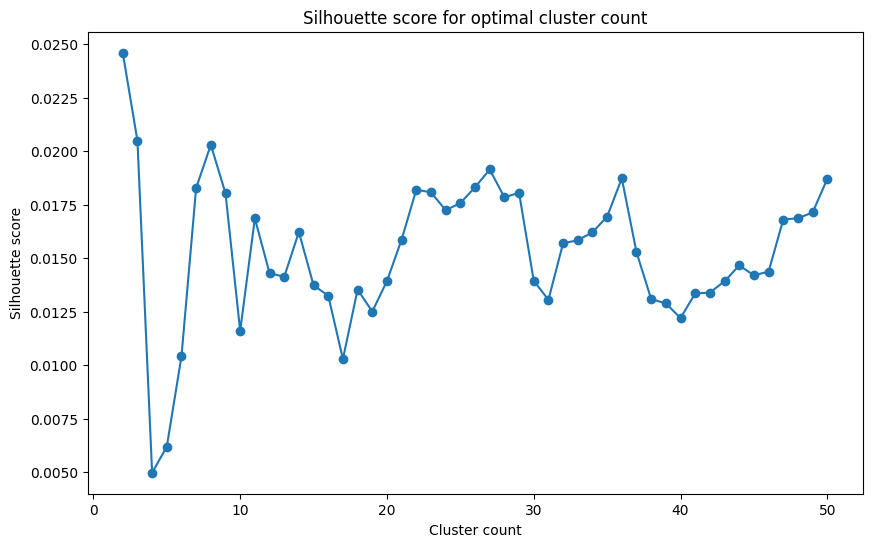

In [3]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

max_clusters = 50

def calculate_silhouette_scores(embeddings, max_clusters):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

silhouette_scores = calculate_silhouette_scores(df['embeddings'].to_list(), max_clusters)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Cluster count')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for optimal cluster count')
plt.show()

In [4]:
model = KMeans(n_clusters=20, max_iter=1000)
model.fit(df['embeddings'].to_list())
df["cluster"] = model.labels_

df.head()

,number,title,state,created_at,updated_at,labels,embeddings,cluster
0,11441,Enable native SOCKS support by default [Featur...,open,2024-08-23T02:11:15Z,2024-08-23T02:13:08Z,NaN,"[-0.017059326171875, 0.041534423828125, 0.0132...",17
1,11440,[DOC] Tweaks to Array#combination,open,2024-08-22T22:10:33Z,2024-08-23T03:47:00Z,Documentation,"[-0.015625, 0.0253143310546875, 0.039703369140...",6
2,11438,[PRISM] Fix allocations for keyword splat params,open,2024-08-22T18:38:15Z,2024-08-23T12:57:46Z,NaN,"[-0.00861358642578125, 0.031280517578125, 0.04...",14
3,11437,[Bug #20691] Fix use-after-free in WeakKeyMap#...,open,2024-08-22T16:05:15Z,2024-08-23T03:23:38Z,NaN,"[-0.01070404052734375, 0.04840087890625, 0.035...",17
4,11436,[DOC] Adds remarks about returned Enumerator,open,2024-08-22T15:52:22Z,2024-08-23T04:22:33Z,Documentation,"[-0.008392333984375, 0.01496124267578125, 0.01...",5


In [5]:
df[df["cluster"] == 0]["title"].head()

143                        Implement "mutex reservation"
225    Queue/SizedQueue benchmarks for fibers (& thre...
235     Mark Fibers in Mutex/Queue/SizedQueue wait lists
345                  Unpin inseqs that have been wrapped
346               Raise timeout for test_queue_with_trap
Name: title, dtype: object

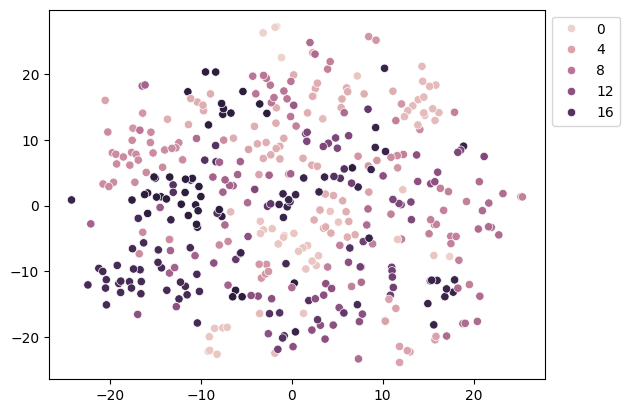

In [6]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['cluster'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [7]:
def select_representative_titles(df, num_titles=20):
    cluster_titles = {}
    for cluster in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster]
        representative_titles = cluster_df['title'].sample(min(num_titles, len(cluster_df)), random_state=42).tolist()
        cluster_titles[cluster] = representative_titles
    return cluster_titles

def generate_category_label(titles):
    prompt = f"""
    Please generate a category name for the following list of titles:
    
    {', '.join(titles)}
    
    The category should show common attributes or topics of the titles but be very specific.
    You must not use general terms like optimization, improvements, fixes, enhancements in the category name.
    Only print the category name and do not include special characters.
    """
    
    chat_response = client.chat.complete(
        model = "mistral-large-latest",
        messages = [
            {
                "role": "user",
                "content": prompt
            },
        ]
    )

    return chat_response.choices[0].message.content

def generate_cluster_labels(representative_titles):
    cluster_labels = {}
    for cluster, titles in representative_titles.items():
        label = generate_category_label(titles)
        cluster_labels[cluster] = label
    return cluster_labels

if not os.path.exists('github_issues_embedded_and_labeled.csv'):
    representative_titles = select_representative_titles(df)
    cluster_labels = generate_cluster_labels(representative_titles)
    df['cluster_label'] = df['cluster'].map(cluster_labels)
    df.to_csv('github_issues_embedded_and_labeled.csv', index=False)
    print("Issues labeled successfully.")
else:
    df = pd.read_csv('github_issues_embedded_and_labeled.csv')
    df['embeddings'] = df['embeddings'].apply(convert_embeddings)
    print("Issues already labeled.")

df.head()[["title", "cluster_label"]]

Issues already labeled.


,title,cluster_label
0,Enable native SOCKS support by default [Featur...,Bug and Feature Reports for Language and Libra...
1,[DOC] Tweaks to Array#combination,Documentation Updates
2,[PRISM] Fix allocations for keyword splat params,Bug and Feature Reports for Language and Libra...
3,[Bug #20691] Fix use-after-free in WeakKeyMap#...,Bug and Feature Reports for Language and Libra...
4,[DOC] Adds remarks about returned Enumerator,Documentation Updates


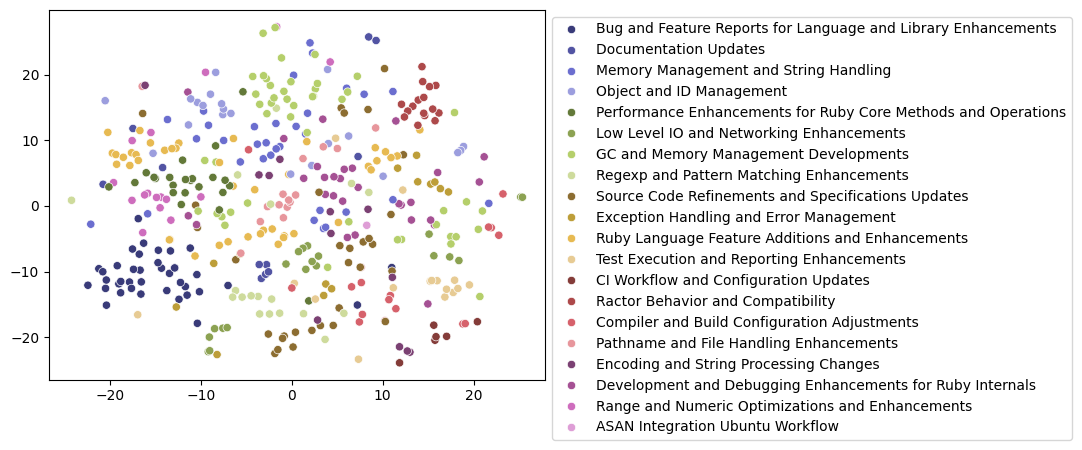

In [8]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['cluster_label'].to_list()), palette='tab20b')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [9]:
pd.set_option('display.max_colwidth', 1000)
df[df['cluster_label'] == 'Bug and Feature Reports for Language and Library Enhancements'].title.head(10)

0                                           Enable native SOCKS support by default [Feature #20673]
2                                                  [PRISM] Fix allocations for keyword splat params
3                                               [Bug #20691] Fix use-after-free in WeakKeyMap#clear
9                         [Bug #20693] Perform an actual access check in Dir.tmpdir for writability
14                                                     [Bug #20662] Preserve payloads in packed NaN
17                                                                                     Debug #11271
33                                                   [Feature #19979] Method definition with `&nil`
46                                                   [Bug #20468] More strictly check loop variable
51                              [Bug #20452] Take main thread address/size with rlimit if musl libc
59    [Feature #20408] Implement heap_live_slots, heap_free_slots, heap_final_slots in GC.stat_heap
